
# Balila, Edwin Klein 2019-22685
# Final Project EE 298 M

## STL-10 using Principal Component Analysis and Gaussian Mixture Model

##### Download STL-10 dataset from https://ai.stanford.edu/~acoates/stl10/

In [4]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import math
from scipy import linalg as la
from sklearn.mixture import GaussianMixture
import pandas as pd
import seaborn as sns

## Dataset Visualization

In [5]:
# code from https://github.com/mttk/STL10
# Function to read the files, referenced from stl10_input.py
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

In [7]:
# Directories of dataset:
x_train = './data/stl10_binary/train_X.bin'
x_test = './data/stl10_binary/test_X.bin'
y_train = './data/stl10_binary/train_Y.bin'
y_test = './data/stl10_binary/test_Y.bin'
# Unlabeled dataset
x_unlabeled = './data/stl10_binary/unlabeled_X.bin'

In [8]:
# Plotting and image conversion functions:
# function for plotting. code from # from https://github.com/roatienza/ml/blob/master/pca/notebook/pca.ipynb
# plot only 1 image
def plot_images(images, title = 'default', n_images=1):
    plt.figure(figsize=(5,5))
    plt.suptitle(title, fontsize=20)
    side = int(math.sqrt(n_images))
    for i in range(n_images):
        plt.subplot(side, side, i + 1)
        image = images[i]
        plt.imshow(image,cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
    plt.show()
    plt.close('all')  

# convert to gray scale
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

### Plot first Image

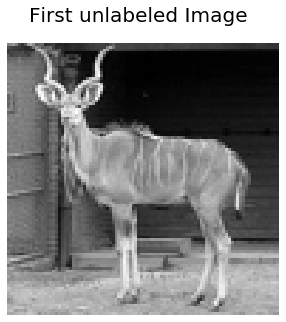

In [9]:
# read image labels
unlabeled_images = read_all_images(x_unlabeled)
unlabeled_images = np.array([rgb2gray(i) for i in unlabeled_images])
title = "First unlabeled Image"
plot_images(unlabeled_images, title=title)
orig_shape = unlabeled_images.shape

# PCA ALGORITHM

### Mean subtraction:
$$\begin{equation*}
\textbf{ x }_{n} = \textbf{x}_{n} - \mu
\end{equation*}$$

### Divide by standard deviation:¶
$$\begin{equation*}
\textbf{ x }_{n} = \textbf{x}_{n} / \sigma
\end{equation*}$$

### Formulate data matrix and covariance matrix:
$$
\textbf{X} = [ \textbf{x}_1, ..., \textbf{x}_n ]
$$$$
\textbf{S} = \frac{1}{N}\textbf{XX}^T
$$

### Perform Eigendecomposition
$$\textbf{S}=\textbf{B}\textbf{D}\textbf{B}^{-1}$$

### Projection or Low-Rank Approximation of $\textbf{X}$: 
$$
\textbf{R} = \textbf{B}_{M}\textbf{B}^{T}_{M}\textbf{X}
$$

### Backprojection:
$$\begin{equation*}
\textbf{ x }_{n} = \textbf{x}_{n}\sigma + \mu
\end{equation*}$$

### Perform PCA
Part 1: Low-dimensionality reduction using PCA

Using STL-10 10k unlabeled dataset, build a PCA with the minimum dimensionality and best reconstruction quality
Plot 𝑀𝑆𝐸 vs 𝒛−𝑑𝑖𝑚

Mean squared error for the entire test set vs 𝒛 code dimensionality

Try the following dims: {32, 64, 256, 512, 1028, 2046, 4098}

In [11]:
# from https://github.com/roatienza/ml/blob/master/pca/notebook/pca.ipynb

def PCA(orig,components):
    #create a mean-centered X
    images = orig
    mu = np.mean(images)
    images -= mu 
    
    # get the covariance matrix
    cov = np.cov(images , rowvar = False)
    
    # Perform Eigendecomposition
    eigVal,eigVec = la.eig(cov)

    # Projection or Low-Rank Approximation of X:
    BM = eigVec[:,0:components]
    BM_BMT = np.dot(BM.T,images.T).T
    
    # Back Project
    R = np.dot(BM_BMT, BM.T)
    R += mu
    R = np.reshape(R,orig.shape)
    
    # returns reduced dim image and reconstructed image
    return BM_BMT, R

# define mean squred error function
def MSE(orig, new):
    return np.abs((np.square(orig- new)).mean(axis=None))



### Perform PCA on given dims {32, 64, 256, 512, 1028, 2046, 4098}

In [284]:
# sample first 10000 images from unlabeled dataset
orig_images = unlabeled_images[0:10000]

# flatten the image
orig = orig_images.reshape(len(orig_images),-1)

# create vector for principal components for plotting
principal_components = [32, 64, 256, 512, 1028, 2046, 4098]
# create vector for MSE for plotting
MSE_vec = []

# apply PCA to different dimensions and cget the mean square error
for i in principal_components:
    reducedM,reconstructed_images = PCA(orig,i)
    reduced_reshape = np.reshape(reconstructed_images,orig_images.shape)
    Mean_Square_Error = MSE(orig_images,reduced_reshape)
    print('Dim =', i, "   Mean Squared Error = ", Mean_Square_Error)
    MSE_vec.append(Mean_Square_Error)

Dim = 32    Mean Squared Error =  0.274126731819022
Dim = 64    Mean Squared Error =  0.2119785020897349
Dim = 256    Mean Squared Error =  0.11334498844033149
Dim = 512    Mean Squared Error =  0.0750339289296502
Dim = 1028    Mean Squared Error =  0.04305874227661418
Dim = 2046    Mean Squared Error =  0.018912460376018667
Dim = 4098    Mean Squared Error =  0.004119053066015563


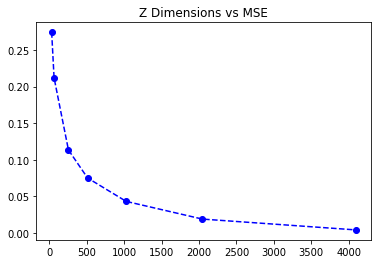

In [285]:
# Plot the MSE
plt.plot(principal_components, MSE_vec, '--bo')
plt.title('Z Dimensions vs MSE')
plt.show()
plt.close('all')

## Verify result with Test Data

In [286]:
# load x_test from directory
x_test_images = read_all_images(x_test)
# convert to grayscale
x_test_images = np.array([rgb2gray(i) for i in x_test_images])

# flatten the image
orig = x_test_images.reshape(len(x_test_images),-1)

# create vector for test MSE for plotting
MSE_test_vec = []

# apply PCA to different dimensions and get the mean square error
for i in principal_components:
    reducedM,reconstructed_test_images = PCA(orig,i)
    reduced_reshape = np.reshape(reconstructed_test_images,x_test_images.shape)
    Mean_Square_Error_test = MSE(x_test_images,reduced_reshape)
    print('Dim =', i, "   Mean Squared Error = ", Mean_Square_Error_test)
    MSE_test_vec.append(Mean_Square_Error_test)

Dim = 32    Mean Squared Error =  13642.570604049723
Dim = 64    Mean Squared Error =  906.8090145363458
Dim = 256    Mean Squared Error =  480.40855073182234
Dim = 512    Mean Squared Error =  313.4503355298549
Dim = 1028    Mean Squared Error =  174.30542695202212
Dim = 2046    Mean Squared Error =  70.66778962657207
Dim = 4098    Mean Squared Error =  12.45413078247386


Discard the dimension = 32 since we all know based on the the resulting high MSE and for the reason that it can not reconstruct the original image

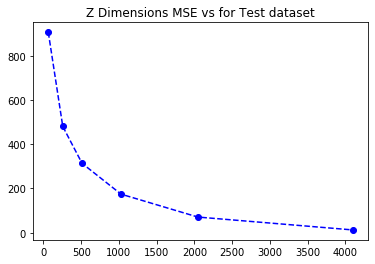

In [293]:
# Plot the MSE for test dataset
# discard the outlier Dim=32
plt.plot(principal_components[1:7], MSE_test_vec[1:7], '--bo')
plt.title('Z Dimensions MSE vs for Test dataset')
plt.show()
plt.close('all')

Comparing the results of unlabled MSE and test data MSE , we cannot choose dim=4098 eventhough it has the lowest MSE.

We can chose our optimal Zdim = 1028 with MSE = 0.49

# Reconstruction of test dataset using 1028 components
## Original Test Data VS Reconstructed Data

In [296]:
# load x_test from directory
x_test_images = read_all_images(x_test)
# convert to grayscale
x_test_images = np.array([rgb2gray(i) for i in x_test_images])
# flatten the image
orig = x_test_images.reshape(len(x_test_images),-1)
# use PCA with dim=1028
reduced_m_1028,reconstructed_images_1028 = PCA(orig,1028)

In [302]:
# test data has complex values
reconstructed_images_1028_abs = np.abs(reconstructed_images_1028)
reconstructed_images_1028_abs = np.reshape(reconstructed_images_1028_abs,x_test_images.shape)
reconstructed_images_1028_abs.shape

(8000, 96, 96)

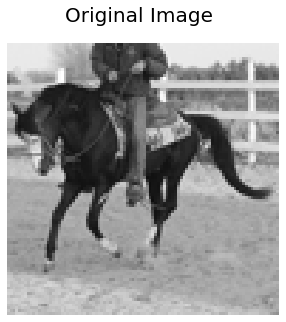

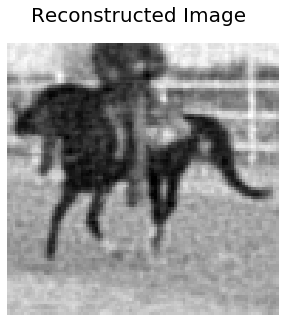

In [303]:
# plot original image and recontructed image
x_test_images = read_all_images(x_test)
x_test_images = np.array([rgb2gray(i) for i in x_test_images])
title = "Original Image"
plot_images(x_test_images, title=title)
#orig_shape = x_test_images.shape

title = "Reconstructed Image"
plot_images(reconstructed_images_1028_abs, title=title)

# Gaussian Mixture Model

Can we fit a 10-component GMM on the unlabeled dataset 𝒛 code vectors from PCA?

Can we use the GMM and labeled train set to assign labels to the 10 clusters in GMM?

Report the accuracy on the test dataset.

Can we build an STL generative model using unlabeled dataset PCA 𝒛 code vectors and GMM?

In [12]:
# get 10000 sample images from unlabled dataset
orig_images = unlabeled_images[0:10000]
# flatten the image
orig = orig_images.reshape(len(orig_images),-1)
# perform PCA
Xn,reconstructed_unlabeled_1028 = PCA(orig,1028)

In [13]:
# check shape
Xn.shape

(10000, 1028)

In [14]:
# fit 10-component GMM 
gm = GaussianMixture(n_components=10, covariance_type='full')
gm.fit(Xn)
outlier_scores = gm.score_samples(Xn)

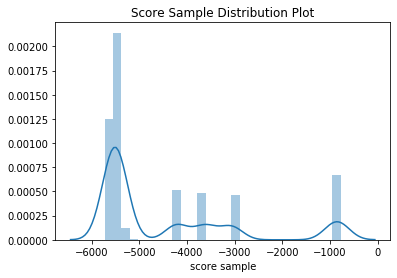

In [15]:
# Check for outlier threshold
sns.distplot(outlier_scores);
plt.xlabel("score sample")
plt.title("Score Sample Distribution Plot")
plt.show()

In [16]:
# predict clusters
clusters = gm.predict(Xn)

In [17]:
# table and print the clusters to see the labels
labels_frame = pd.DataFrame(clusters)
labels_frame.T

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,7,2,3,1,0,6,2,3,6,4,...,9,9,0,1,2,2,7,3,5,0


Label values are from 0 to 9

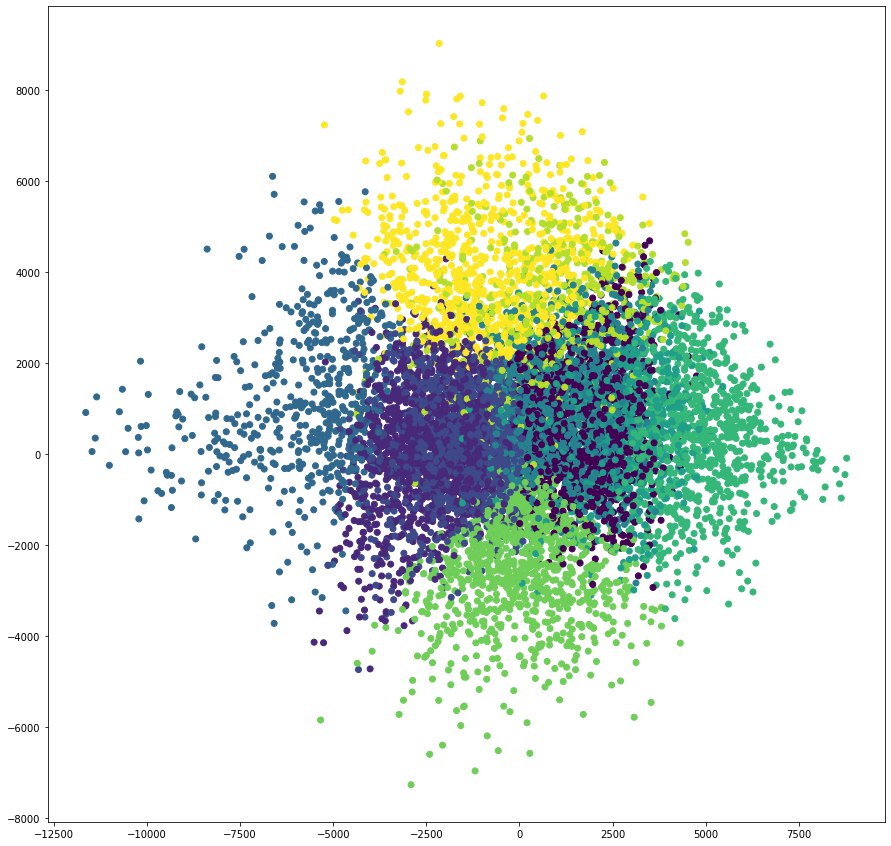

In [18]:
# lets plot the scatterplot to see distribution of the 10 components
fig = plt.figure(figsize=(15,15))
plt.scatter(Xn[:, 0], Xn[:, 1], c=clusters, cmap='viridis');

As we can see in the scatter plot, we can see the distribution of the clustered data points. We can see on the scatter point that some datapoints can be clustered and some are hard to determine its distribution. 

## Use GMM on labeled train dataset

In [121]:
# read x_train data set
x_train_images = read_all_images(x_train)
x_train_images = np.array([rgb2gray(i) for i in x_train_images])
x_train_orig_images = x_train_images
# flatten the image
x_train_orig_images = x_train_images.reshape(len(x_train_images),-1)
x_train_images.shape

(5000, 96, 96)

In [122]:
# use PCA with z dim = 1024
Xn_2, reconstructed_x_train1028 = PCA(x_train_orig_images,1028)

In [123]:
# results are getting complex values. take the absolute
Xn_2_abs = np.abs(Xn_2)
reconstructed_x_train1028_abs = np.abs(reconstructed_x_train1028)

In [124]:
# use gmm 
x_traingmm = GaussianMixture(n_components=10, covariance_type='full')
x_traingmm.fit(Xn_2_abs)
outlier_scores = x_traingmm.score_samples(Xn_2_abs)

# predict clusters
gmm_labels = x_traingmm.predict(Xn_2_abs)

In [125]:
np.unique(gmm_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [126]:
# the predicted label starts from 0 so we need to add 1 to compare it with y_train dataset
gmm_labels_ = gmm_labels
gmm_labels_ += 1
gmm_labels_pd = pd.DataFrame(gmm_labels_)
v = gmm_labels_pd.T
v # check

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,7,7,7,8,7,5,7,10,10,1,...,4,7,5,3,10,8,2,7,7,5


In [127]:
np.unique(gmm_labels_)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [128]:
# read y_train data set
y_train_images = read_labels(y_train)
y_train_images_pd = pd.DataFrame(y_train_images)

class labels based on the './data/stl10_binary/class_names.txt'

The following labels corresponds the following values.

airplane = 1

bird     = 2

car      = 3

cat      = 4

deer     = 5

dog      = 6

horse    = 7

monkey   = 8

ship     = 9

truck    = 10

In [129]:
# visualize the table joining the predicted label and the y_train label
labels_arr = [[gmm_labels_[i],y_train_images[i]] for i in range(len(y_train_images))]
labels_arr_pd = pd.DataFrame(labels_arr)
labels_arr_pd.T

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,7,7,7,8,7,5,7,10,10,1,...,4,7,5,3,10,8,2,7,7,5
1,2,6,2,7,4,10,8,5,6,9,...,2,7,10,4,5,2,6,2,8,6


In [130]:
# dataframe of predicted labels
gmm_labels_pd = pd.DataFrame(gmm_labels_)

# check if the predicted value and y_train values are the same
check = y_train_images_pd.eq(gmm_labels_pd)
chc = check.astype(int)
# outputs 1 if correctly clustered 0 otherwise
check.T

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [172]:
# probability of success
unique, frequency = np.unique(check,return_counts = True)
frequency
# Overall accuracy
p = frequency[1]/5000
p

0.1006

Overall clustering, 10.06% accuracy based on the frequency of correct clustering

In [137]:
# visualize the table for indexing
labels_arr111 = [np.array_equal(y_train_images[i],gmm_labels_[i]) for i in range(len(y_train_images))]
labels_arr111 = np.array(labels_arr111)
labels_arr111_1 = labels_arr111.astype(int)
labels_arr111_1

fg = [(y_train_images,labels_arr111_1)]
fg = np.array(fg)
fg.shape

fg = fg.reshape(2,5000)
fg = fg.T

fg1 = pd.DataFrame(fg)
fg1.T

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,2,6,2,7,4,10,8,5,6,9,...,2,7,10,4,5,2,6,2,8,6
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [134]:
# functions to get probability of success clustering
def getIndex_(images,label,fg):
    index = np.where(images == label)
    indx = np.array(index)
    id_ = []
    
    for i in index:
        id_.append([fg[i]])
    
    id_ = np.array(id_)
    id_ = id_.reshape(len(indx.T),2)
    id_g = id_.T
    
    
    unique, frequency = np.unique(id_,return_counts = True)
    unique1, frequency1 = np.unique(id_g[:][1],return_counts = True)
    
    prob = frequency1[1]/500
    
    return id_ , prob

In [170]:
p_vec = []
for i in range(10):
    clus, P = getIndex_(y_train_images,i+1,fg)
    p_vec.append(P)
# shows probability of success vector
p_vec

[0.074, 0.138, 0.026, 0.162, 0.06, 0.056, 0.184, 0.03, 0.07, 0.206]

<function matplotlib.pyplot.show(*args, **kw)>

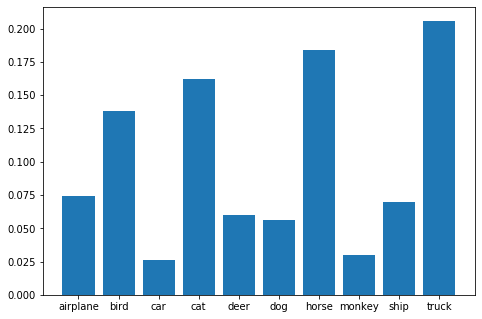

In [161]:
# show plot 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
label_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
ax.bar(label_names,p_vec)
plt.show

## Checking on test dataset

In [139]:
# read x_train data set
x_test_images = read_all_images(x_test)
x_test_images = np.array([rgb2gray(i) for i in x_test_images])
x_test_orig_images = x_test_images
# flatten the image
x_test_orig_images = x_test_images.reshape(len(x_test_images),-1)
x_test_images.shape

(8000, 96, 96)

In [140]:
# use PCA with z dim = 1024
Xn_3, reconstructed_x_test1028 = PCA(x_test_orig_images,1028)

In [141]:
# results are getting complex values. take the absolute
Xn_3_abs = np.abs(Xn_3)
reconstructed_x_test1028_abs = np.abs(reconstructed_x_test1028)

In [142]:
# use gmm 
x_testgmm = GaussianMixture(n_components=10, covariance_type='full')
x_testgmm.fit(Xn_3_abs)
outlier_scores = x_testgmm.score_samples(Xn_3_abs)

# predict clusters
gmm_labels_test_ = x_testgmm.predict(Xn_3_abs)

In [163]:
# read y_train data set
y_test_labels = read_labels(y_test)
y_test_frame = pd.DataFrame(y_test_labels)
np.unique(gmm_labels_test_)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [147]:
# the predicted label starts from 0 so we need to add 1 to compare it with y_test dataset
gmm_labels_test = gmm_labels_test_
gmm_labels_test += 1
gmm_labels_test_pd = pd.DataFrame(gmm_labels_test)
v_test = gmm_labels_test_pd.T
v_test # check

,0,1,2,3,4,5,6,7,8,9,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,5,2,3,2,1,1,7,8,4,5,...,4,5,1,7,1,6,5,6,8,3


In [164]:
# visualize the table joining the predicted label and the y_test label
labels_arr_test = [[gmm_labels_test[i],y_test_labels[i]] for i in range(len(y_test_labels))]
labels_arr_test_pd = pd.DataFrame(labels_arr_test)
#labels_arr_test_pd.T

In [165]:
# dataframe of predicted labels
gmm_labels_test_pd = pd.DataFrame(gmm_labels_test)

# check if the predicted value and y_test values are the same
check_test = y_test_frame.eq(gmm_labels_test_pd)
chc_test = check_test.astype(int)
# outputs False if correctly clustered 0 otherwise
check_test.T

,0,1,2,3,4,5,6,7,8,9,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [166]:
unique_test, frequency_test = np.unique(check_test,return_counts = True)
# Overall accuracy
p_test = frequency_test[1]/5000
p_test

0.1788

Test dataset has a 17.88% chance of clustering correctly

In [153]:
# visualize the table for indexing
labels_arr111_test = [np.array_equal(y_test_labels[i],gmm_labels_test[i]) for i in range(len(y_test_labels))]
labels_arr111_test = np.array(labels_arr111_test)
labels_arr_test_1 = labels_arr111_test.astype(int)
labels_arr_test_1

fg_test = [(y_test_labels,labels_arr_test_1)]
fg_test = np.array(fg_test)
fg_test.shape

fg_test = fg_test.reshape(2,8000)
fg_test = fg_test.T

fg1_test = pd.DataFrame(fg_test)
fg1_test.T

,0,1,2,3,4,5,6,7,8,9,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,7,8,6,1,4,2,2,2,5,5,...,10,4,3,9,6,10,7,9,9,9
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [168]:
# Calculate prob of success
p_vec_test = []
for i in range(10):
    clus_test, P_test = getIndex_(y_test_labels,i+1,fg_test)
    p_vec_test.append(P_test)
# shows probability of success vector
p_vec_test

[0.144, 0.48, 0.158, 0.032, 0.266, 0.09, 0.136, 0.052, 0.262, 0.168]

<function matplotlib.pyplot.show(*args, **kw)>

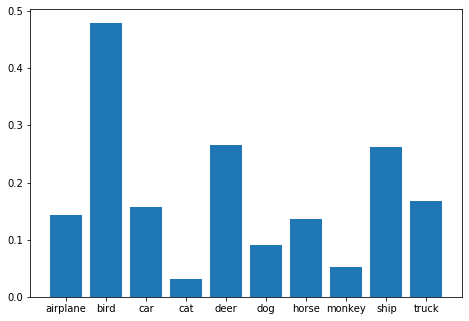

In [169]:
# show bar plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
label_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
ax.bar(label_names,p_vec_test)
plt.show

# Conclusion

Based on the calculated probability of success, the clustering of 10 components has a very high chance of getting it wrong. Therefore, we cannot generate a model using PCA dataset z code vectors and GMM.